In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
data_path='/content/drive/MyDrive/archive.zip'
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data has been extracted.')

The data has been extracted.


In [ ]:
csv_path = '/content/GroundTruth.csv'
df = pd.read_csv(csv_path)
print(df.head())


          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [ ]:
df['image'] = df['image'].apply(lambda x: x + ".jpg")

In [ ]:
df['class'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

In [ ]:
df_final = df[['image', 'class']]
print(df_final.head())

              image class
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [ ]:
from sklearn.model_selection import train_test_split

# First split into train+val and test
df_trainval, df_test = train_test_split(df_final, test_size=0.1, stratify=df_final['class'], random_state=42)

# Then split train+val into train and val
df_train, df_val = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval['class'], random_state=42)


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
IMAGES_PATH = '/content/images'


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_PATH,
    x_col='image',
    y_col='class',
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE)
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=IMAGES_PATH,
    x_col='image',
    y_col='class',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE)
)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_PATH,
    x_col='image',
    y_col='class',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE)
)


Found 7210 validated image filenames belonging to 7 classes.
Found 1803 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


In [ ]:
model=Sequential ([Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),MaxPooling2D(pool_size=(2,2)),
                   Conv2D(64,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),MaxPooling2D(pool_size=(2,2)),
                   Conv2D(128,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),MaxPooling2D(pool_size=(2,2)),
                   Flatten(),
                   Dense(128,activation='relu'),Dropout(0.5),
                   Dense(7,activation='softmax')])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,879 (56.61 MB)

 Trainable params: 14,839,879 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_generator,epochs=20,validation_data=val_generator,callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 86s 348ms/step - accuracy: 0.6320 - loss: 1.3906 - val_accuracy: 0.6694 - val_loss: 0.9553
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 284ms/step - accuracy: 0.6841 - loss: 0.9570 - val_accuracy: 0.6689 - val_loss: 0.8906
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - accuracy: 0.6789 - loss: 0.9249 - val_accuracy: 0.6739 - val_loss: 0.9072
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 284ms/step - accuracy: 0.6898 - loss: 0.8831 - val_accuracy: 0.6761 - val_loss: 0.8374
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 90s 320ms/step - accuracy: 0.6820 - loss: 0.8587 - val_accuracy: 0.6861 - val_loss: 0.8124
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 282ms/step - accuracy: 0.6952 - loss: 0.8321 - val_accuracy: 0.6750 - val_loss: 0.8345
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 62s 276ms/step - accuracy: 0.6957 - loss: 0.8059 - val_accuracy: 0.7033 - val_loss: 0.7964
Epoch 8/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - accuracy: 0.7145 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6955 - loss: 0.7966

Test Accuracy: 0.7036


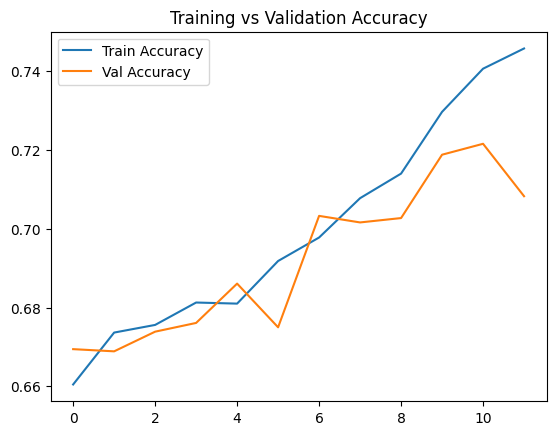

In [ ]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

model.save("skin_disease_cnn_model2.h5")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from google.colab import drive


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D

feature_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D()
])

datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    dataframe=df_final,
    directory=IMAGES_PATH,
    x_col="image",
    y_col="class",
    subset="training",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

total_images = 10015
features = []

for i in range((total_images + 31) // 32):
    images, _ = next(train_gen)
    batch_features = feature_model.predict(images)
    features.append(batch_features)
    print(f"Batch {i+1} done, features: {len(np.concatenate(features))}")

features = np.concatenate(features)[:total_images]
print("Features Shape:", features.shape)


Found 10015 validated image filenames belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 1 done, features: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Batch 2 done, features: 64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Batch 3 done, features: 96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Batch 4 done, features: 128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Batch 5 done, features: 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Batch 6 done, features: 192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Batch 7 done, features: 224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Batch 8 done, features: 256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Batch 9 done, features: 288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Batch 10 done, features: 320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Batch 11 done, features: 352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Batch 12 done, features: 384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Batch 13 done, features: 416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Batch 14 done, features: 448
1/1 ━━━

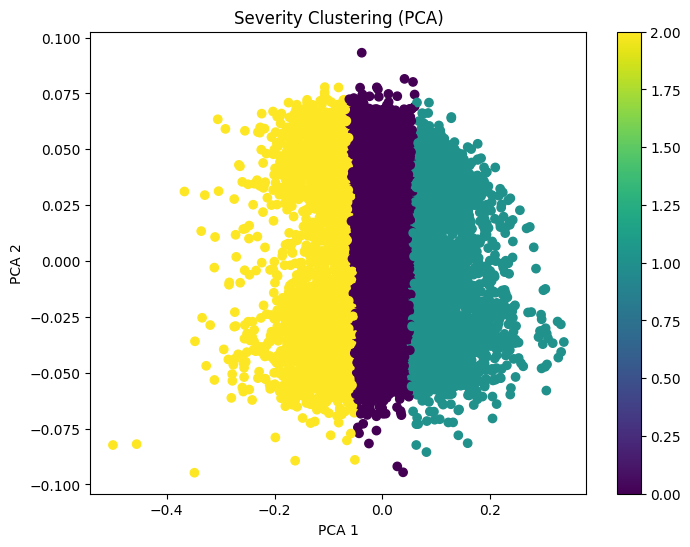

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, random_state=42)
severity_clusters = kmeans.fit_predict(features)

cluster_to_severity = {
    0: 'early',
    1: 'mild',
    2: 'severe'
}

severity_labels = [cluster_to_severity[label] for label in severity_clusters]

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=severity_clusters, cmap='viridis')
plt.title('Severity Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


In [ ]:
import joblib
joblib.dump(kmeans, 'severity_model.pkl2')
print("KMeans model saved!")


KMeans model saved!


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
model = load_model('/content/skin_disease_cnn_model2.h5')  # Replace with your actual model path


In [ ]:
val_generator.reset()  # Reset to make sure prediction and labels match


In [ ]:
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


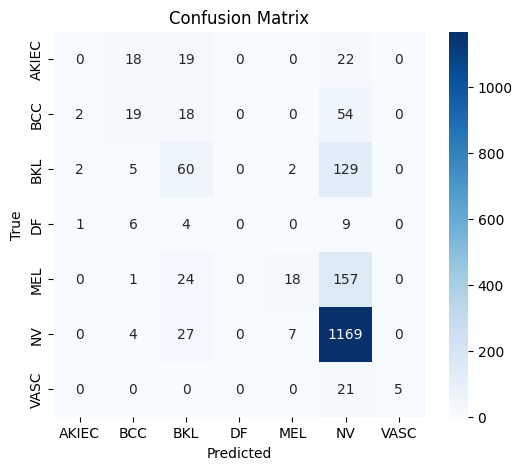

In [ ]:
class_names = list(val_generator.class_indices.keys())  # e.g., ['Literal', 'Metaphorical']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
